In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers
import seaborn as sns

from sklearn.model_selection import train_test_split



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from yellowbrick.model_selection import learning_curve
from sklearn.tree import export_graphviz

from pydotplus import graph_from_dot_data
from IPython.display import Image
import itertools
import copy

## Reading and Exploring Data

In [ ]:
#read csv file
data = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [ ]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [ ]:
#checking if the data has any null value
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

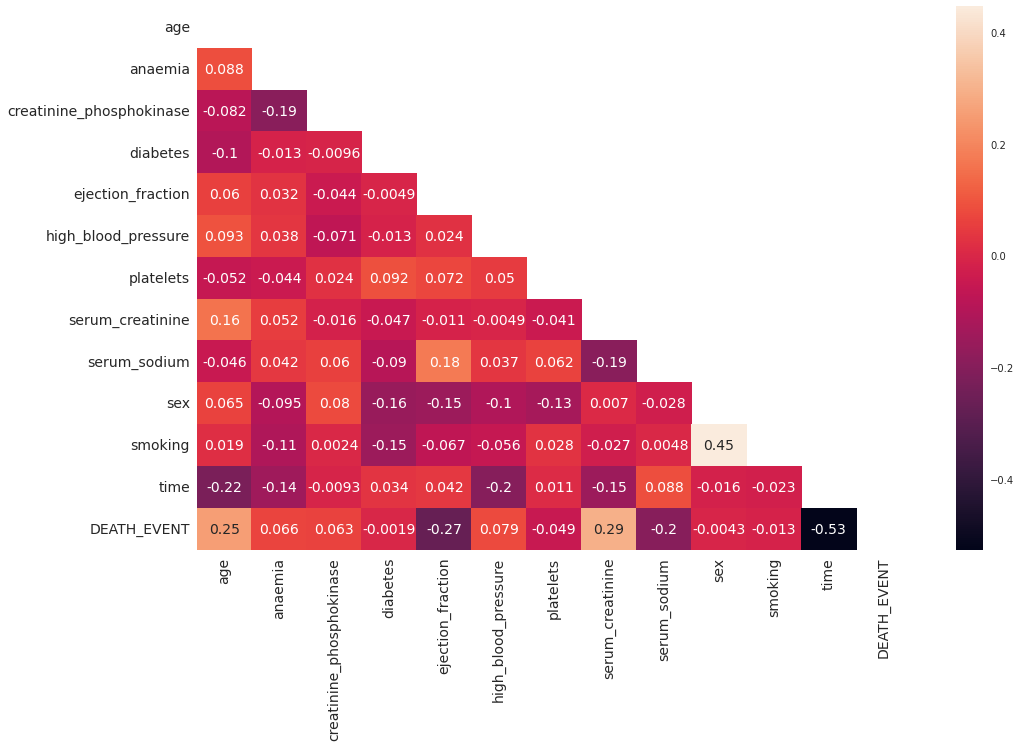

In [ ]:
#plotting a features heatmap so we could understand correlation among features

#creating a mask to remove duplicate correlation values
mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True



#plotting the heatmap
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

from the heatmap we could see that the most 4 imprtant features are 'age', 'ejection_fraction', 'serum_creatinine' and 'time'. The least two imprtant features are sex and diabetes. Lower correlation features like 'sex' were not removed due to the fact that they might be an important clinical features, the data is very small so we couldn't judge how actually important they are, so we kept them.

## Data Analysis

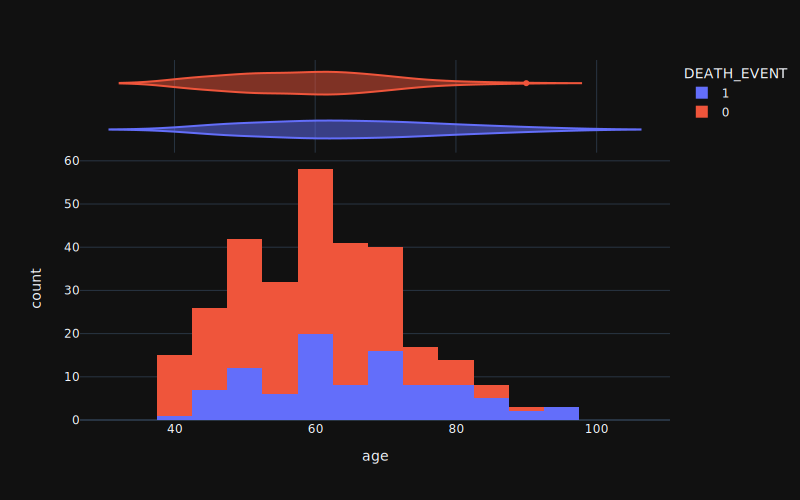

In [ ]:
#Age histogram
fig = px.histogram(data, x="age", color="DEATH_EVENT", marginal="violin", hover_data=data.columns, width=800, height=500, template="plotly_dark")
fig.show(renderer="svg")

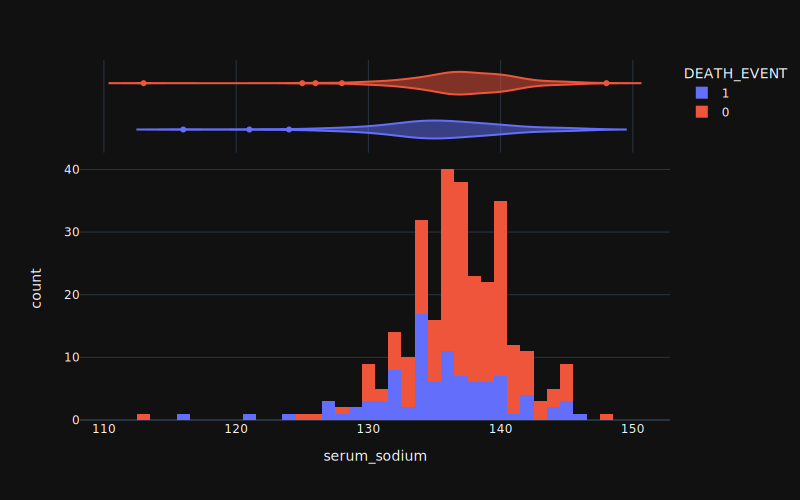

In [ ]:
#serum sodium histogram
fig = px.histogram(data, x="serum_sodium", color="DEATH_EVENT", marginal="violin", hover_data=data.columns, width=800, height=500, template="plotly_dark")
fig.show(renderer="svg")

In [ ]:
#creating a function to create pie plots
def pie_plot(feature_name):
  d1 = data[(data["DEATH_EVENT"]==0) & (data[f"{feature_name}"]==0)]
  d2 = data[(data["DEATH_EVENT"]==0) & (data[f"{feature_name}"]==1)]
  d3 = data[(data["DEATH_EVENT"]==1) & (data[f"{feature_name}"]==0)]
  d4 = data[(data["DEATH_EVENT"]==1) & (data[f"{feature_name}"]==1)]
  values = [(len(d1)+len(d3)), (len(d2)+len(d4))]
  values2 = [len(d1),len(d2),len(d3),len(d4)]

  #create subplots
  fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
  fig.add_trace(go.Pie(labels=[f"No {feature_name}",f"{feature_name}"], values=values, name=''),1, 1)
  fig.add_trace(go.Pie(labels=[f'No {feature_name} - Survived',f'{feature_name} - Survived', f"No {feature_name} -  Died", f"{feature_name}  - Died"],values=values2, name=''), 1, 2)

  #set figure title, size and theme
  fig.update_layout(
    title_text=f"{feature_name} Distribution In The Dataset \
                                      {feature_name} VS DEATH_EVENT", width=1200, height=500, template="plotly_dark")


  fig.show(renderer="svg")

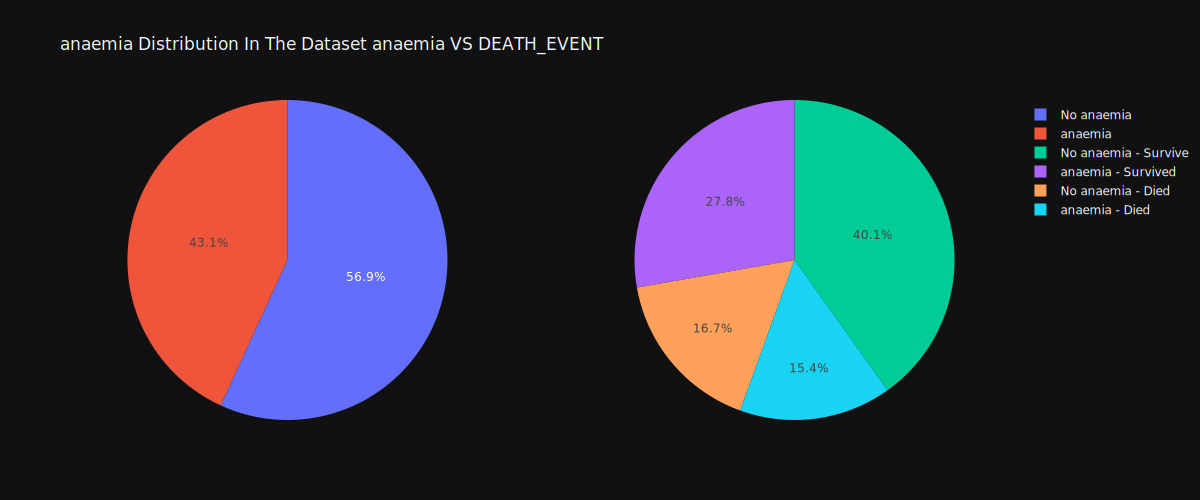

In [ ]:
#Anaemia analysis
pie_plot('anaemia')

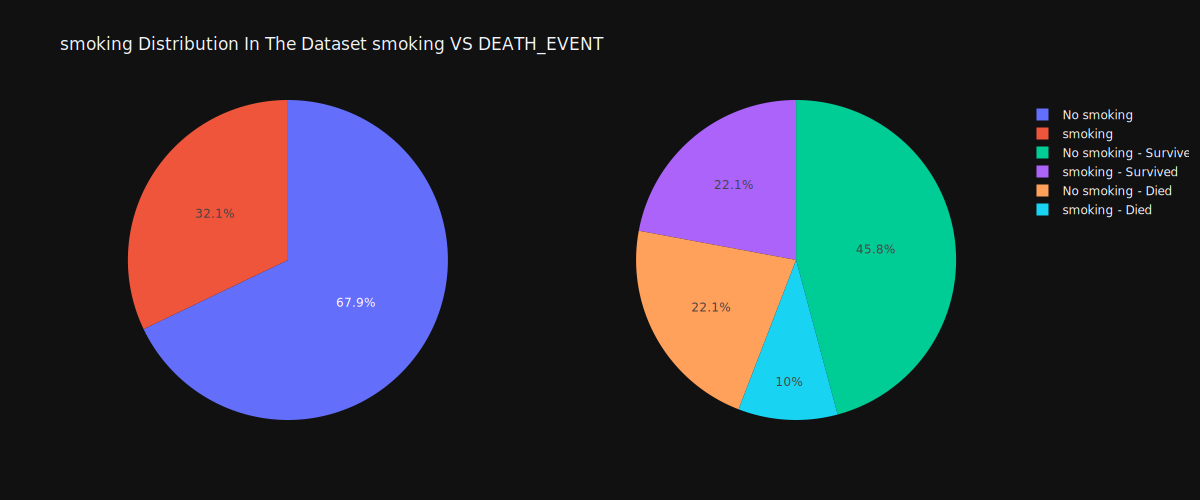

In [ ]:
#Smoking effect on the dataset
pie_plot('smoking')

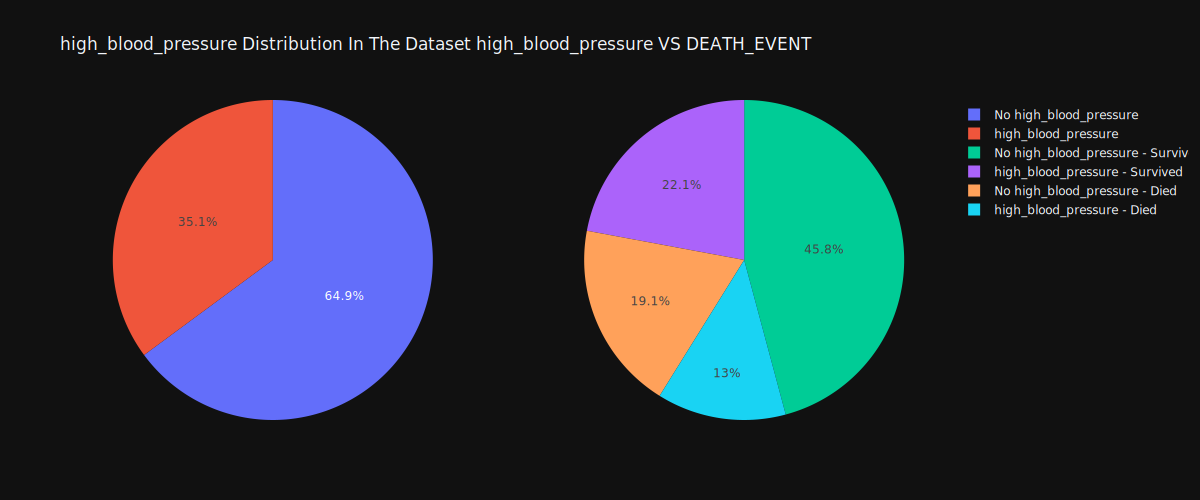

In [ ]:
#high blood pressure analysis
pie_plot('high_blood_pressure')

## Data Modeling

from looking at the heatmap we could say that from a machine learning point of view the most 3 important features are 'ejection_fraction', 'serum_creatinine' and 'time'. Thusly, we will be choosing these features to work with them

In [ ]:
#splitting to an numpy arrays of features and the target
X = data[['ejection_fraction', 'serum_creatinine', 'time']]
y = data["DEATH_EVENT"]

due to the fact that the dataset is small, the accuracy scores and model performance will be completly random depending on which portion of data is given as train and test sets. So, we will create a dataframe to help us pick the best random seed to split the data into train and test sets

In [ ]:
df1 = pd.DataFrame(columns=('LR', 'RFC', 'DTC', 'KNN', 'SVM', 'GBC', 'XGBRF', 'LGB', 'CBC', 'GPC', 'Ada', 'BC'))

for i in range(0,21):
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
  LR = LogisticRegression()
  RFC = RandomForestClassifier()
  DTC = DecisionTreeClassifier()
  KNN = KNeighborsClassifier()
  SVM = SVC()
  GBC = GradientBoostingClassifier()
  XGBRF = XGBRFClassifier()
  LGB = LGBMClassifier()
  CBC = CatBoostClassifier()
  GPC = GaussianProcessClassifier()
  Ada = AdaBoostClassifier()
  BC = BaggingClassifier()

  df1.loc[i] = [LR.fit(X_train, y_train).score(X_test, y_test), RFC.fit(X_train, y_train).score(X_test, y_test), DTC.fit(X_train, y_train).score(X_test, y_test),
                KNN.fit(X_train, y_train).score(X_test, y_test), SVM.fit(X_train, y_train).score(X_test, y_test), GBC.fit(X_train, y_train).score(X_test, y_test),
                XGBRF.fit(X_train, y_train).score(X_test, y_test), LGB.fit(X_train, y_train).score(X_test, y_test), CBC.fit(X_train, y_train, silent=True).score(X_test, y_test),
                GPC.fit(X_train, y_train).score(X_test, y_test), Ada.fit(X_train, y_train).score(X_test, y_test), BC.fit(X_train, y_train).score(X_test, y_test)]

In [ ]:
#sorting the data frame
df1.sort_values(['LR', 'RFC', 'DTC', 'KNN', 'SVM', 'GBC', 'XGBRF', 'LGB', 'CBC', 'GPC', 'Ada', 'BC'], ascending=False)

,LR,RFC,DTC,KNN,SVM,GBC,XGBRF,LGB,CBC,GPC,Ada,BC
7,0.900000,0.933333,0.850000,0.933333,0.916667,0.933333,0.916667,0.950000,0.933333,0.950000,0.916667,0.950000
2,0.900000,0.883333,0.833333,0.916667,0.900000,0.950000,0.933333,0.883333,0.933333,0.900000,0.900000,0.916667
4,0.900000,0.816667,0.766667,0.816667,0.850000,0.850000,0.816667,0.833333,0.866667,0.800000,0.816667,0.833333
16,0.883333,0.900000,0.850000,0.900000,0.900000,0.916667,0.883333,0.916667,0.933333,0.833333,0.933333,0.866667
3,0.883333,0.866667,0.783333,0.866667,0.850000,0.816667,0.850000,0.850000,0.883333,0.850000,0.850000,0.833333
13,0.883333,0.850000,0.833333,0.900000,0.883333,0.883333,0.900000,0.850000,0.900000,0.850000,0.816667,0.850000
12,0.866667,0.916667,0.783333,0.916667,0.900000,0.883333,0.916667,0.900000,0.933333,0.850000,0.883333,0.833333
1,0.866667,0.883333,0.800000,0.883333,0.900000,0.866667,0.833333,0.833333,0.883333,0.833333,0.866667,0.850000
5,0.866667,0.850000,0.800000,0.833333,0.816667,0.833333,0.833333,0.850000,0.833333,0.866667,0.816667,0.833333
15,0.850000,0.866667,0.816667,0.883333,0.883333,0.866667,0.850000,0.833333,0.866667,0.816667,0.833333,0.816667


we can say that the best random seed is 7

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

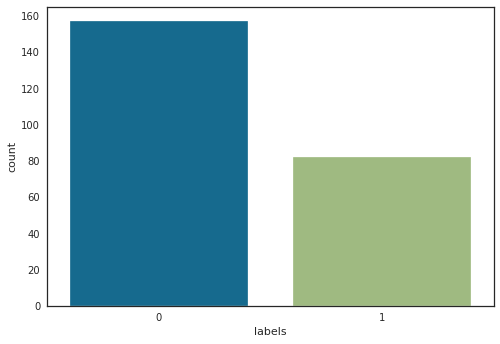

In [ ]:
#checking train data balance
df_train = pd.DataFrame()
df_train["labels"]= y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(x=lab)
plt.show()

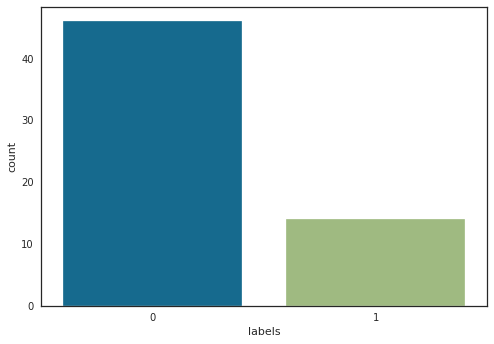

In [ ]:
#checking test data balance
df_test = pd.DataFrame()
df_test["labels"]= y_test
lab = df_test['labels']
dist = lab.value_counts()
sns.countplot(x=lab)
plt.show()

We will write a class that we're going to use in grid search to tune the hyper paramteres of our models. This class works by training the model on the training set and evaluating it on the test set

In [ ]:
class GridSearch:


  def __init__(self, model, parameter_grid):
    self.model = model
    self.parameter_grid = parameter_grid
    self.best_model_ = None
    self.best_params_ = dict()

  def generate_permutations(self):
    keys = self.parameter_grid.keys()
    vals = self.parameter_grid.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

  def fit_test(self, X_train, y_train, X_test, y_test):
    dummy = list(self.generate_permutations())
    keys = list(dummy[0].keys())
    best_score = 0.0
    scores = []
    for para in dummy:
      self.model.set_params(**para)
      self.model.fit(X_train, y_train)
      score = self.model.score(X_test, y_test)
      scores.append(score)
      if score >= best_score:
        best_score = score
        self.best_params_ = self.model.get_params(deep=False)
        self.best_model_ = copy.deepcopy(self.model)
    self.plot_curve(scores)

  def plot_curve(self,scores):
    fig = px.line(
        pd.DataFrame({
            'Iterations': range(len(scores)),
            'Scores': scores
        }),
        x='Iterations',
        y='Scores',
        template="plotly_dark",
        width=800, height=500)
    fig.update_layout(title={
        'text': f'{type(self.model).__name__} Model Accuracy Graph',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    fig.show(renderer="svg")

In [ ]:
#fucntion to plot the confsuion matrix
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Failure']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

1 - Logistic Regression

In [ ]:
logistic_parameter_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
logistic_grid_search = GridSearch(LogisticRegression(), logistic_parameter_grid)

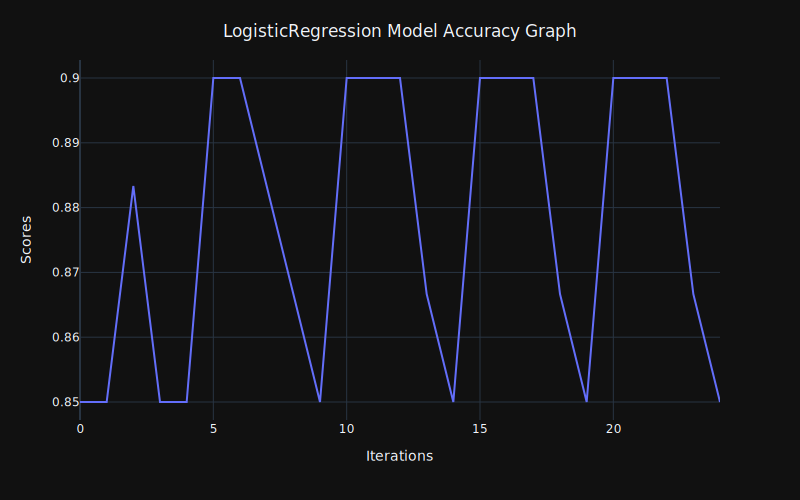

In [ ]:
logistic_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
LR = logistic_grid_search.best_model_

In [ ]:
LR.score(X_test, y_test)

0.9

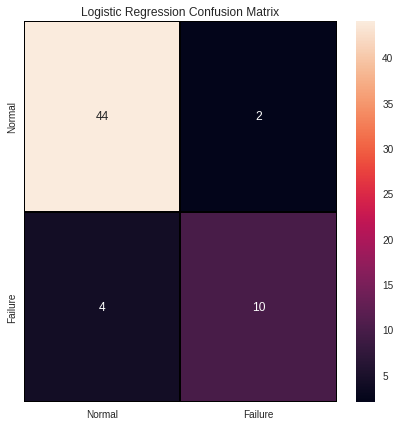

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(LR.predict(X_test), y_test, 'Logistic Regression Confusion Matrix')

2 - Random Forest Classifier

In [ ]:
random_forest_parameter_grid = {
        'max_depth': range(1,20),
        'n_estimators': np.arange(10,150,20),
        'class_weight': ['balanced', 'balanced_subsample']

    }
random_forest_grid_search = GridSearch(RandomForestClassifier(), random_forest_parameter_grid)

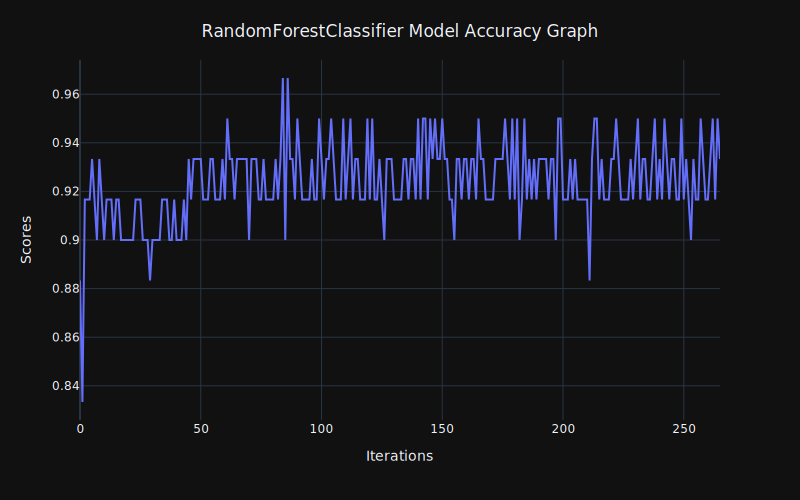

In [ ]:
random_forest_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
RFC = random_forest_grid_search.best_model_

In [ ]:
RFC.score(X_test, y_test)

0.9666666666666667

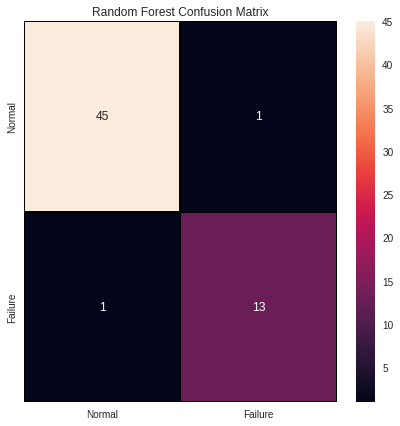

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(RFC.predict(X_test), y_test, 'Random Forest Confusion Matrix')

3 - Decision Tree Classifier

In [ ]:
decision_tree_parameter_grid = {
        'max_depth': range(1,20),
        'min_samples_leaf': range(1,20)
    }
decision_tree_grid_search = GridSearch(DecisionTreeClassifier(), decision_tree_parameter_grid)

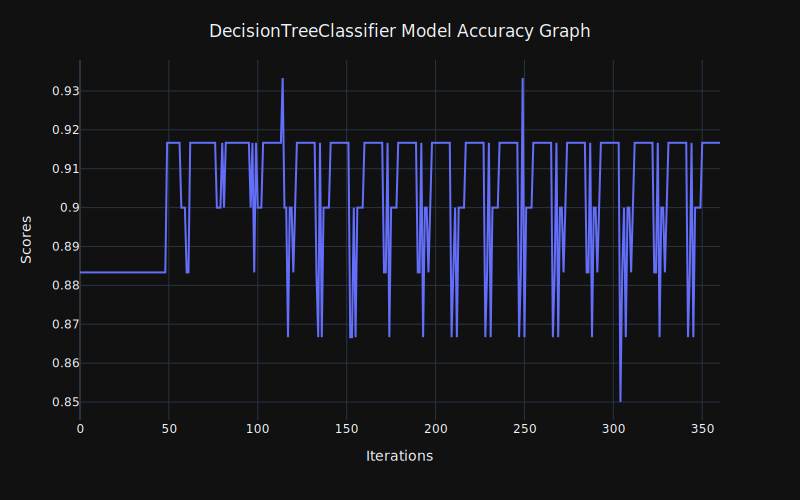

In [ ]:
decision_tree_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
DTC = decision_tree_grid_search.best_model_

In [ ]:
DTC.score(X_test, y_test)

0.9333333333333333

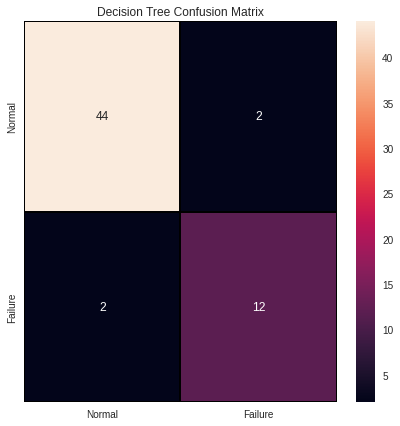

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(DTC.predict(X_test), y_test, 'Decision Tree Confusion Matrix')

4 - KNN

In [ ]:
KNN_parameter_grid = {
        'n_neighbors': range(1,20),
        'metric': ['minkowski', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
KNN_grid_search = GridSearch(KNeighborsClassifier(), KNN_parameter_grid)

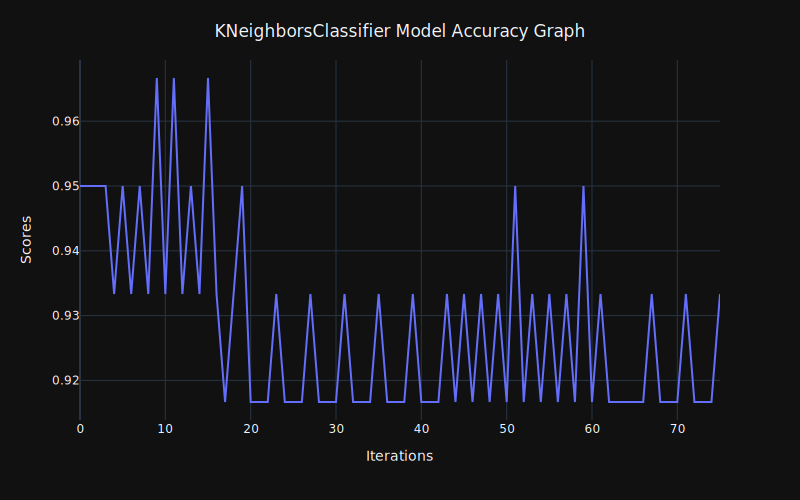

In [ ]:
KNN_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
KNN = KNN_grid_search.best_model_

In [ ]:
KNN.score(X_test, y_test)

0.9666666666666667

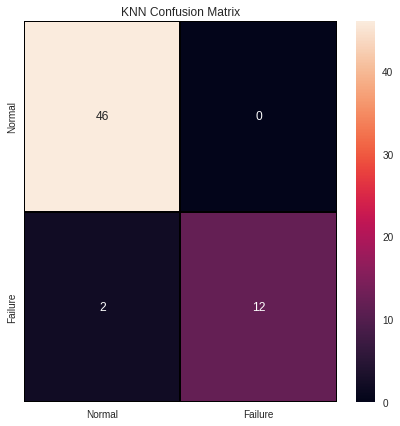

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(KNN.predict(X_test), y_test, 'KNN Confusion Matrix')

5 - Support Vector Machine

In [ ]:
SVM_parameter_grid = {
         'C': [0.1,1, 10, 100],
         'gamma': [1,0.1,0.01,0.001]
         }
SVM_grid_search = GridSearch(SVC(), SVM_parameter_grid)

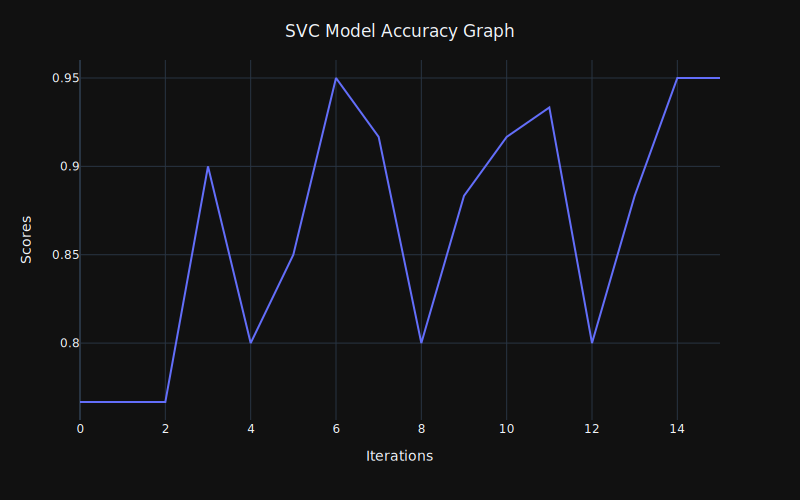

In [ ]:
SVM_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
SVM = SVM_grid_search.best_model_

In [ ]:
SVM.score(X_test, y_test)

0.95

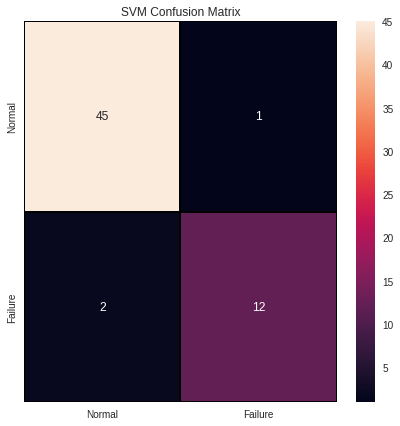

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(SVM.predict(X_test), y_test, 'SVM Confusion Matrix')

6 - Gradient Boosting Classifier

In [ ]:
GBC_parameter_grid = {
         'n_estimators': np.arange(10,150,10),
         'max_depth': range(1,20),
         'learning_rate': [0.001, 0.01, 0.1]
         }
GBC_grid_search = GridSearch(GradientBoostingClassifier(), GBC_parameter_grid)

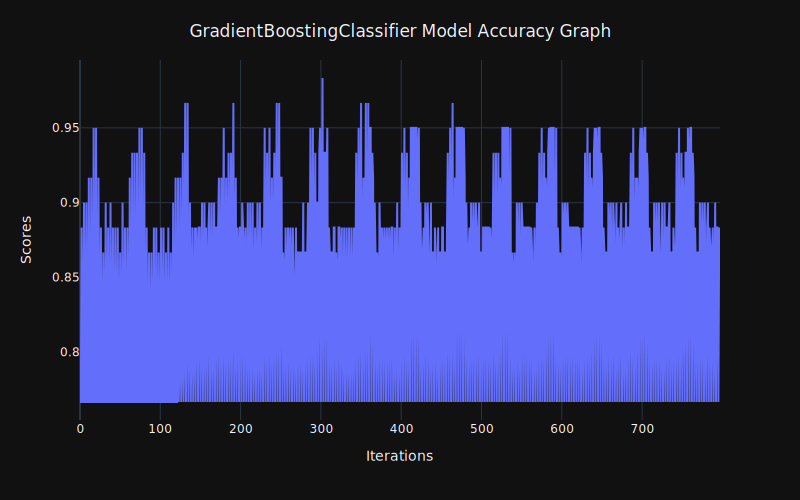

In [ ]:
GBC_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
GBC = GBC_grid_search.best_model_

In [ ]:
GBC.score(X_test, y_test)

0.9833333333333333

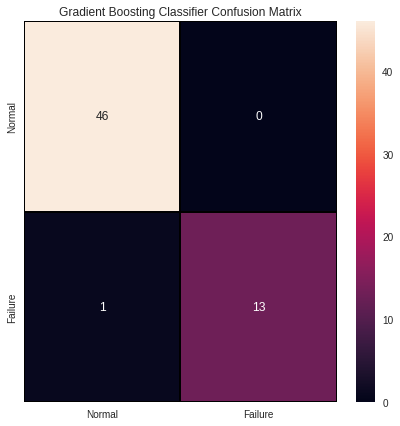

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(GBC.predict(X_test), y_test, 'Gradient Boosting Classifier Confusion Matrix')

7 - XGBRF

In [ ]:
XGBRF_parameter_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
XGBRF_grid_search = GridSearch(XGBRFClassifier(), XGBRF_parameter_grid)

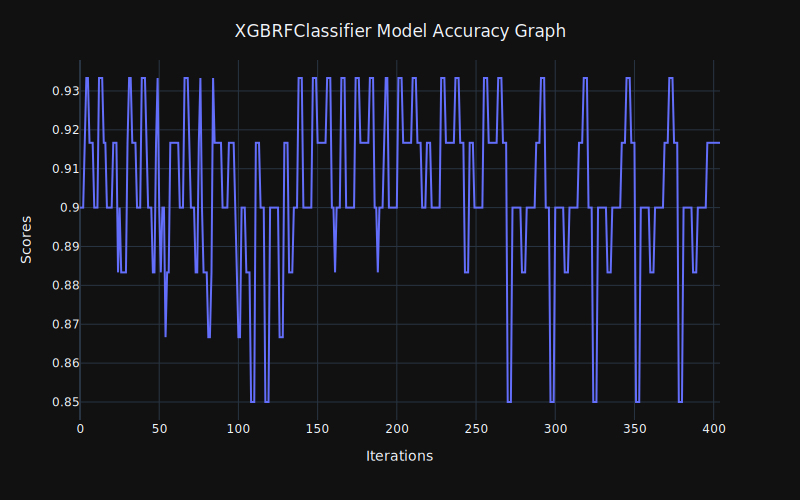

In [ ]:
XGBRF_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
XGBRF = XGBRF_grid_search.best_model_

In [ ]:
XGBRF.score(X_test, y_test)

0.9333333333333333

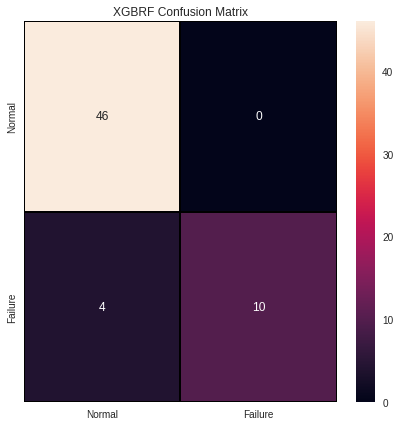

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(XGBRF.predict(X_test), y_test, 'XGBRF Confusion Matrix')

8 - LGBM

In [ ]:
LGBM_parameter_grid = {
        'max_depth': [-1, 1, 2, 3, 4, 5, 6],
        'n_estimators': np.arange(10,150,10)
        }
LGBM_grid_search = GridSearch(LGBMClassifier(), LGBM_parameter_grid)

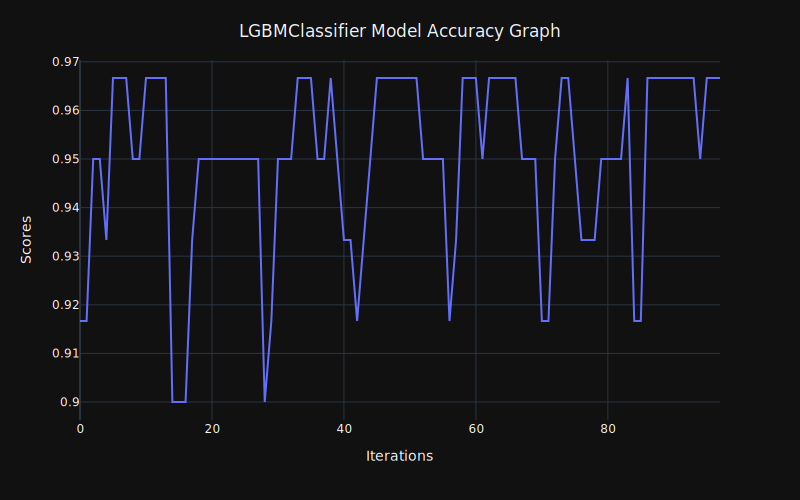

In [ ]:
LGBM_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
LGBM = LGBM_grid_search.best_model_

In [ ]:
LGBM.score(X_test, y_test)

0.9666666666666667

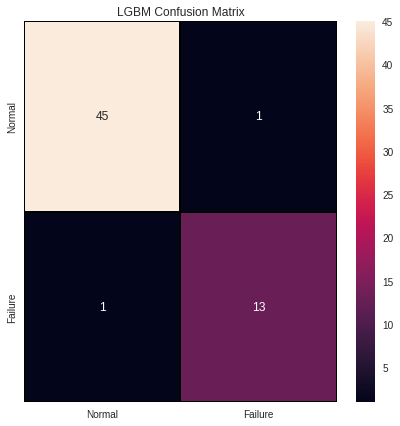

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(LGBM.predict(X_test), y_test, 'LGBM Confusion Matrix')

8 - CBC

In [ ]:
CBC = CatBoostClassifier()
CBC.fit(X_train, y_train, silent=True)

In [ ]:
CBC.score(X_test, y_test)

0.9333333333333333

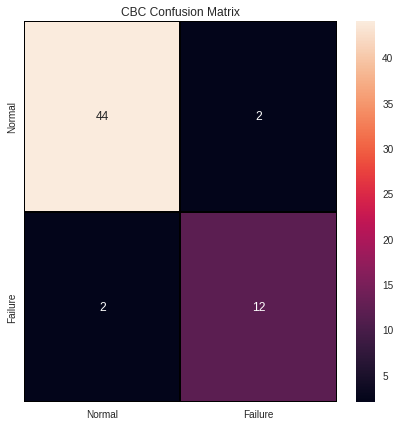

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(CBC.predict(X_test), y_test, 'CBC Confusion Matrix')

9 - Gaussian Process Classifier

In [ ]:
GPC = GaussianProcessClassifier()
GPC.fit(X_train, y_train)

GaussianProcessClassifier()

In [ ]:
GPC.score(X_test, y_test)

0.95

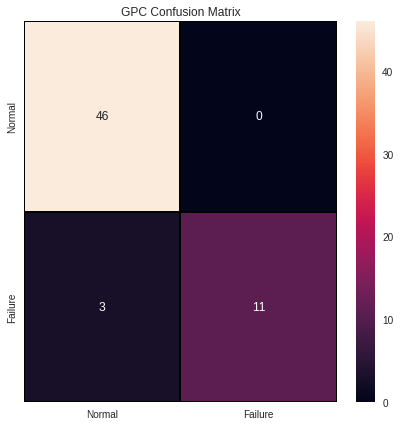

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(GPC.predict(X_test), y_test, 'GPC Confusion Matrix')

10 - Ada

In [ ]:
Ada_parameter_grid = {
    "n_estimators": np.arange(10,150,10),
    'learning_rate': [0.001, 0.01, 0.1]
    }
Ada_grid_search = GridSearch(AdaBoostClassifier(), Ada_parameter_grid)

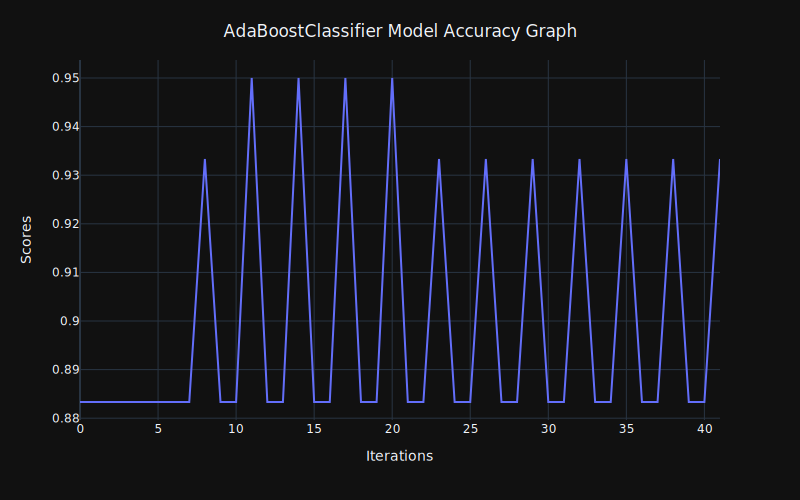

In [ ]:
Ada_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
Ada = Ada_grid_search.best_model_

In [ ]:
Ada.score(X_test, y_test)

0.95

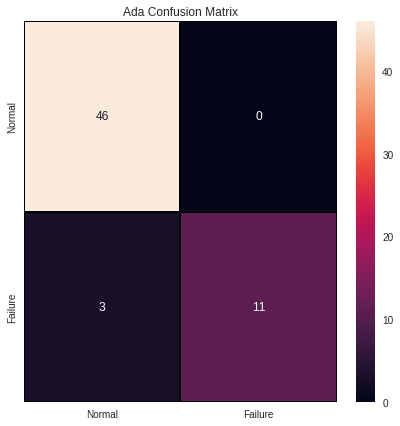

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(Ada.predict(X_test), y_test, 'Ada Confusion Matrix')

12 - Bagging Classifier

In [ ]:
BC_parameter_grid = {
    'n_estimators': np.arange(10,150,10),
    }
BC_grid_search = GridSearch(BaggingClassifier(), BC_parameter_grid)

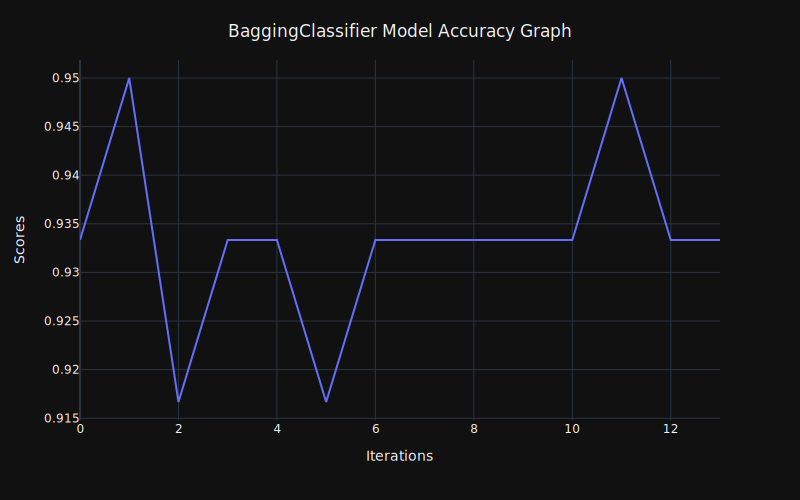

In [ ]:
BC_grid_search.fit_test(X_train, y_train, X_test, y_test)

In [ ]:
BC = BC_grid_search.best_model_

In [ ]:
BC.score(X_test, y_test)

0.95

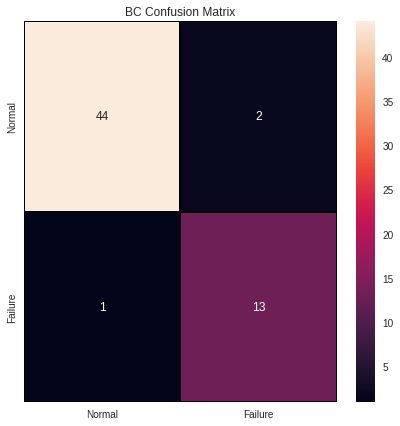

In [ ]:
#plot the confsuion matrix of the best logistic regresssion model
plot_cm(BC.predict(X_test), y_test, 'BC Confusion Matrix')

after training and optimizing the models. we view their metrics

In [ ]:
models_metrics_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
     'F1-score': []
})
models_list = [LR, RFC, DTC, KNN, SVM, GBC, XGBRF, LGBM, CBC, GPC, Ada, BC]
models_scores_list = []

for i, model in enumerate(models_list):
  tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
  accuracy = model.score(X_test, y_test)
  models_scores_list.append(accuracy)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score =  (2 * precision * recall) / (precision + recall)
  #models_metrics_df[f'{type(model).__name__}'] = [accuracy, precision, recall, f1_score]
  models_metrics_df.loc[i] = [f'{type(model).__name__}', accuracy, precision, recall, f1_score]

In [ ]:
models_metrics_df

,Model,Accuracy,Precision,Recall,F1-score
0,LogisticRegression,0.900000,0.833333,0.714286,0.769231
1,RandomForestClassifier,0.966667,0.928571,0.928571,0.928571
2,DecisionTreeClassifier,0.933333,0.857143,0.857143,0.857143
3,KNeighborsClassifier,0.966667,1.000000,0.857143,0.923077
4,SVC,0.950000,0.923077,0.857143,0.888889
5,GradientBoostingClassifier,0.983333,1.000000,0.928571,0.962963
6,XGBRFClassifier,0.933333,1.000000,0.714286,0.833333
7,LGBMClassifier,0.966667,0.928571,0.928571,0.928571
8,CatBoostClassifier,0.933333,0.857143,0.857143,0.857143
9,GaussianProcessClassifier,0.950000,1.000000,0.785714,0.880000


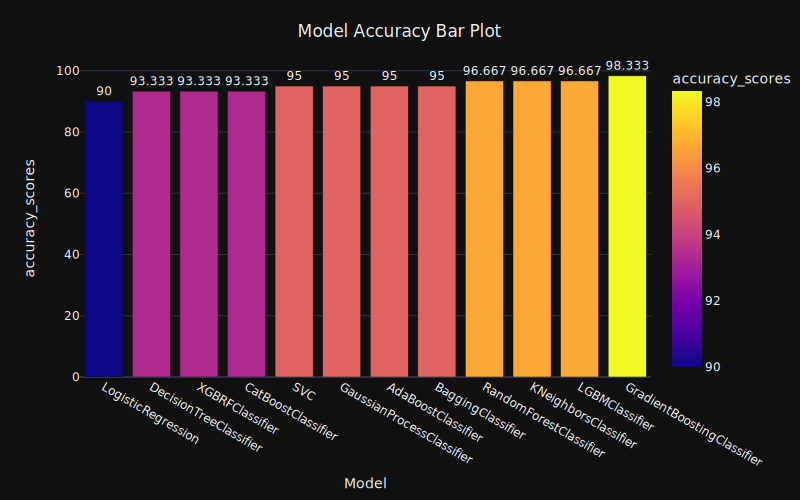

In [ ]:
#bar plot of model accuracies
model_name = []
for model in models_list:
  model_name.append(f'{type(model).__name__}')

for i in range(len(models_scores_list)):
  models_scores_list[i] = round(models_scores_list[i] * 100, 3)

fig = px.bar(
        pd.DataFrame({
            'Model': model_name,
            'accuracy_scores': models_scores_list
        }), x='Model', y='accuracy_scores', color='accuracy_scores', text='accuracy_scores',template="plotly_dark", width=800, height=500)
fig.update_layout(title={
        'text': 'Model Accuracy Bar Plot',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, barmode='stack', xaxis={'categoryorder':'total ascending'})
fig.update_traces(textposition='outside')

fig.show(renderer="svg")

from all of the previous we could deduce that the best model is the Gradient Boosting Classifier model, which is the model that is used for this project.

#The Best Model

In [ ]:
#making preidctions using the Gradient Boosting Classifier model
GBC_predictions = GBC.predict(X_test)

for true, prediction in zip(y_test, GBC_predictions):
  print('Actual: ' + str(true) + '\t' + 'Pridiction: ' + str(prediction))

Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridiction: 1
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridiction: 1
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridiction: 1
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridiction: 1
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridiction: 1
Actual: 1	Pridiction: 1
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 0	Pridiction: 0
Actual: 1	Pridic

In [ ]:
#classification report
print(classification_report(y_test, GBC_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.93      0.96        14

    accuracy                           0.98        60
   macro avg       0.99      0.96      0.98        60
weighted avg       0.98      0.98      0.98        60



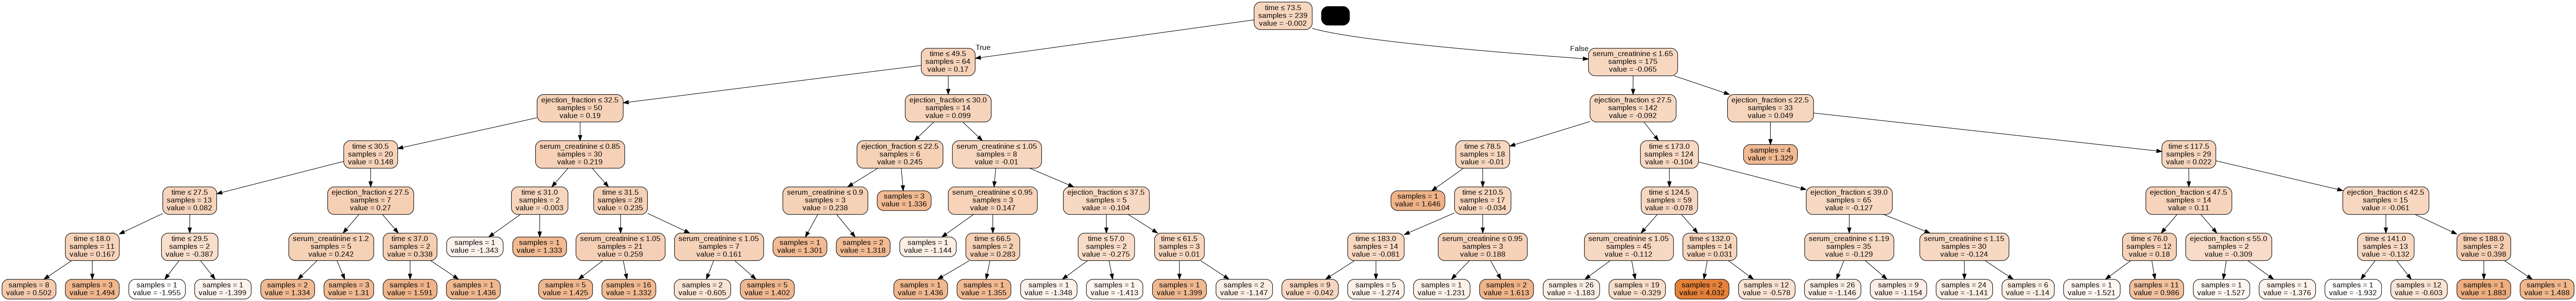

In [ ]:
#visulaising one of the trees of the Gradient Boosting Classifier
sub_tree_10 = GBC.estimators_[10, 0]

tree_data = export_graphviz(
    sub_tree_10,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, feature_names = ['ejection_fraction', 'serum_creatinine', 'time']
)
graph = graph_from_dot_data(tree_data)
Image(graph.create_png())